# This notebook contains examples for the various geometric operations you can perform on the track data. 

## This may be useful for processing your raw data into a cleaner, more regular, more manageable format. You have the option of modifying the data in place (overwriting), or writing to another folder to preserve the original data.

[Reprojecting CRS](#Reprojecting_CRS)

___

In [2]:
import trackio as tio
import glob
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import rasterio as rio
import geopandas as gp
from rasterio.plot import show

___
## Let's start with some of the raw AIS data:

In [3]:
#define raw data files
data_path = './files'
files = glob.glob(f'{data_path}/*clipped_to_polygon*.csv')

#create the Dataset
ds = tio.read(raw_files=files,
              data_path='example00')


No dataset.db found in c:\code\trackio\notebooks\example00. 
Using default units/crs. 
Edit self.meta and then run self.refresh_meta to update.



___
## Group and split the data

In [4]:
#split the raw point data by agents
ds = ds.group_points(groupby='MMSI',
                     col_mapper=tio.mappers.columns,                        
                     meta_cols=['MMSI'],
                     data_cols=['Time',
                                'X',
                                'Y',
                                'Coursing',
                                'Speed'],
                     prefix='Vessel_',
                     ncores=4)

#split using spatiotemporal thresholds
ds = ds.split_tracks_spatiotemporal(time=3600*24, #time in seconds
                                    distance=0.5, #distance in CRS units (degrees here)
                                    ncores=4)

#refresh the metadata
ds = ds.refresh_meta(ncores=4)

ds

Grouping points: 100%|██████████| 1/1 [00:00<00:00, 333.30it/s]


Refreshing metadata: 100%|██████████| 163/163 [00:02<00:00, 72.48it/s]


New meta/databases saved to c:\code\trackio\notebooks\example00


Type:
    <class 'trackio.Dataset.Dataset'>
Status:
    0 Unprocessed CSV Files
    0 Processed CSV Files
    0 Unsplit Agent Files
    163 Split Agent Files
Static Data Fields:
    ['Agent ID', 'MMSI']
Dynamic Data Fields:
    ['Coursing', 'Speed', 'Time', 'X', 'Y']
Metadata:
    X: degrees
    Y: degrees
    CRS: EPSG:4326
Data Path:
    c:\code\trackio\notebooks\example00

___
## Reprojecting CRS

<a id='Reprojecting_CRS'></a>

In [5]:
#get original track
original = ds.get_track(ds.tracks.index[10])

#reproject to another CRS
ds = ds.reproject_crs(3857, ncores=4)

#get reprojected track
reprojected = ds.get_track(ds.tracks.index[10])

Reprojecting CRS: 100%|██████████| 163/163 [00:02<00:00, 65.41it/s]


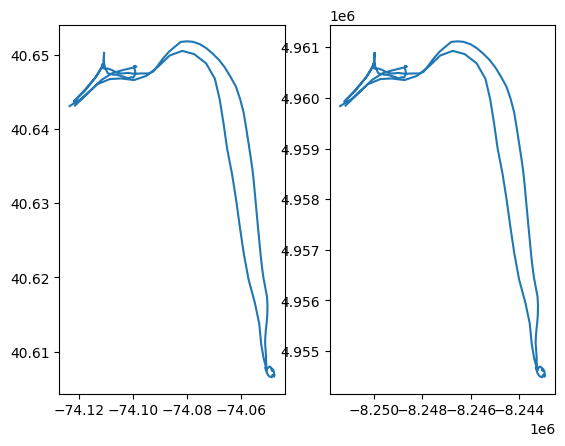

In [6]:
#plot the two
fig, ax = plt.subplots(1,2)
ax[0].plot(original['X'], original['Y'])
ax[1].plot(reprojected['X'], reprojected['Y'])

## Note that the `Dataset.meta` attribute updated the CRS and X,Y units. You'll need to run `Dataset.refresh_meta()` to make this permanent.

In [7]:
ds

Type:
    <class 'trackio.Dataset.Dataset'>
Status:
    0 Unprocessed CSV Files
    0 Processed CSV Files
    0 Unsplit Agent Files
    163 Split Agent Files
Static Data Fields:
    ['Agent ID', 'MMSI']
Dynamic Data Fields:
    ['Coursing', 'Speed', 'Time', 'X', 'Y']
Metadata:
    X: metre
    Y: metre
    CRS: EPSG:3857
Data Path:
    c:\code\trackio\notebooks\example00

___
## Spatial Resampling

In [10]:
#get original track
original = ds.get_track(ds.tracks.index[46])

#resample spacing
ds = ds.resample_spacing(1000,
                         tracks=[ds.tracks.index[46]],
                         ncores=4)

#get resampled track
resampled = ds.get_track(ds.tracks.index[46])

Resampling track spacing: 100%|██████████| 1/1 [00:00<00:00, 391.59it/s]

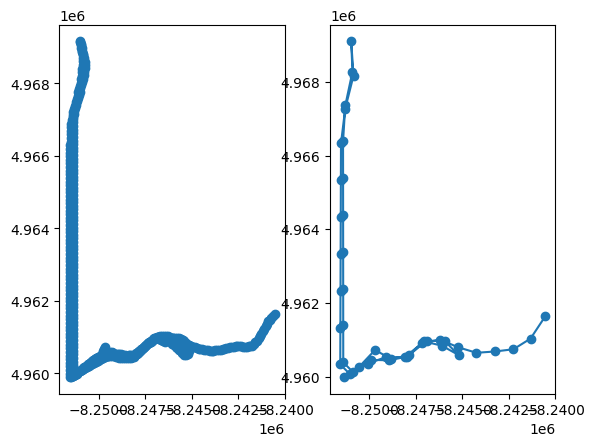

In [11]:
#plot the two
fig, ax = plt.subplots(1,2)
ax[0].plot(original['X'], original['Y'], '-o')
ax[1].plot(resampled['X'], resampled['Y'], '-o')

___
## Temporal Resampling

In [12]:
#define a track id
track_id = ds.tracks.index[9]

#get original track
original = ds.get_track(track_id)

#check existing temporal resolution
ds.tracks.loc[track_id].filter(like='Temporal')

Min Temporal Resolution            10
Mean Temporal Resolution    71.016949
Max Temporal Resolution            91
Name: Vessel_368009360_T0, dtype: object

In [13]:
#temporal resample
ds = ds.resample_time(300, 
                      tracks=[track_id])

#get resampled track
resampled = ds.get_track(track_id)

Resampling track timing: 100%|██████████| 1/1 [00:00<00:00, 264.22it/s]


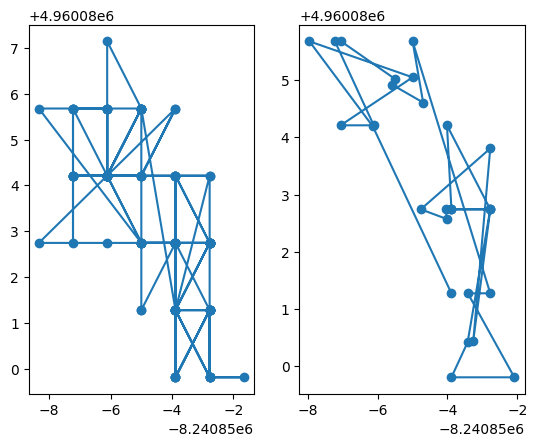

In [14]:
#plot the two
fig, ax = plt.subplots(1,2)
ax[0].plot(original['X'], original['Y'], '-o')
ax[1].plot(resampled['X'], resampled['Y'], '-o')

___
## Global Temporal Resampling

## You can also do a temporal resample to a global time axis. To do this, the time axis must span the times in the entire `Dataset`.

In [15]:
#get time span
tmin = ds.agents['Start Time'].min()
tmax = ds.agents['End Time'].max()

tmin, tmax

(Timestamp('2021-01-01 00:17:12'), Timestamp('2021-01-01 23:59:59'))

In [16]:
#make a new global time axis, 1min intervals
time = pd.date_range('2021-01-01', '2021-01-02', freq='60s')

In [17]:
#temporal resample
ds = ds.resample_time_global(time, 
                             ncores=4)

#refresh meta
ds = ds.refresh_meta(ncores=4)

Refreshing metadata: 100%|██████████| 163/163 [00:02<00:00, 71.76it/s]


New meta/databases saved to c:\code\trackio\notebooks\example00


## Notice the time axis has been interpolated for all tracks now.

In [18]:
ds.tracks.filter(like='Time').head(5)

,Start Time,End Time
Track ID,,
Vessel_368130050_T0,2021-01-01 00:27:00,2021-01-01 19:35:00
Vessel_366756360_T0,2021-01-01 01:24:00,2021-01-01 02:05:00
Vessel_353491000_T0,2021-01-01 07:19:00,2021-01-01 23:59:00
Vessel_367061980_T0,2021-01-01 06:50:00,2021-01-01 09:22:00
Vessel_366999982_T0,2021-01-01 00:20:00,2021-01-01 23:59:00


In [19]:
ds.get_track(track_id)['Time'].head(5)

0   2021-01-01 00:18:00
1   2021-01-01 00:19:00
2   2021-01-01 00:20:00
3   2021-01-01 00:21:00
4   2021-01-01 00:22:00
Name: Time, dtype: datetime64[ns]

___
## Smoothing Sharp Corners

In [22]:
#define track id
track_id = ds.tracks.index[28]

#get original track
original = ds.get_track(track_id)

#smooth the tracks - for jagged corners
ds = ds.smooth_corners(tracks=[track_id],
                       refinements=2)

#get reprojected track
smooth = ds.get_track(track_id)

Smoothing sharp corners: 100%|██████████| 1/1 [00:00<00:00, 142.82it/s]


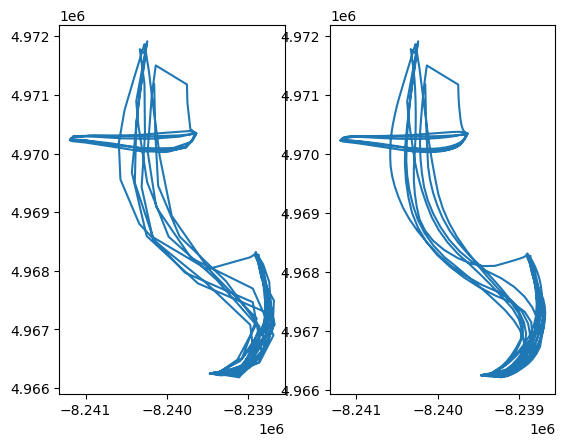

In [23]:
#plot the two
fig, ax = plt.subplots(1,2)
ax[0].plot(original['X'], original['Y'])
ax[1].plot(smooth['X'], smooth['Y'])

___
## Imprinting Geometry into Tracks

Here, imprinting means to take a `shapely.geometry` object and imprint points into tracks where they intersect with the object. The object must be a `LineString`, `MultiLineString`, `Polygon`, or `MultiPolygon` to work.

This is particularly useful for refinining estimates of amount of time spent within polygons.

In [36]:
#define track id
track_id = ds.tracks.index[101]

#get original track
original = ds.get_track(track_id)

#get random point on track
pt = original.iloc[int(len(original)/2)]

#make a circle at this point
point = Point(pt[['X','Y']])
geometry = point.buffer(500)

#imprint the track with this geometry
ds = ds.imprint_geometry(geometry, tracks=[track_id])

#get imprinted
imprinted = ds.get_track(track_id)


Imprinting geometry into tracks:   0%|          | 0/1 [00:00<?, ?it/s]

Imprinting geometry into tracks: 100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


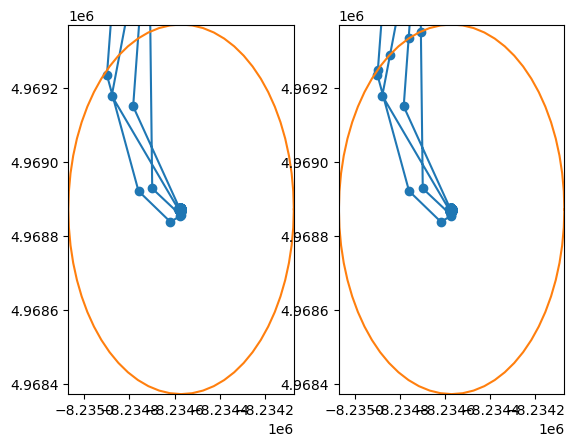

In [37]:
#plot the two
fig, ax = plt.subplots(1,2)
ax[0].plot(original['X'], original['Y'], '-o')
ax[0].plot(*geometry.exterior.xy)
ax[1].plot(imprinted['X'], imprinted['Y'], '-o')
ax[1].plot(*geometry.exterior.xy)
for a in ax:
    a.set_xlim(point.x-500, point.x+500)
    a.set_ylim(point.y-500, point.y+500)

___
## Routing tracks through rasters

Here, a raster refers to a "cost raster". This is a GeoTiff file that contains a cost at each pixel. The algorithm will first see which tracks intersect with the outline of the raster. Then, it will route all segments of that track through the cost raster. The algorithm tries to find the route with the least accumulated cost over the track.

This is a simple wrapper over `sklearn.graph.route_through_array` an accepts all keyword arguments that the original function does, see documentation [here](https://scikit-image.org/docs/stable/api/skimage.graph.html#skimage.graph.route_through_array).

In [49]:
#define track ids
tracks_to_route = gp.read_file('files/route_tracks.gpkg')
track_ids = tracks_to_route['Track ID'].values

#original tracks
original = ds.to_gdf(tracks=track_ids)

Converting tracks to GeoDataFrame: 100%|██████████| 38/38 [00:00<00:00, 999.90it/s]


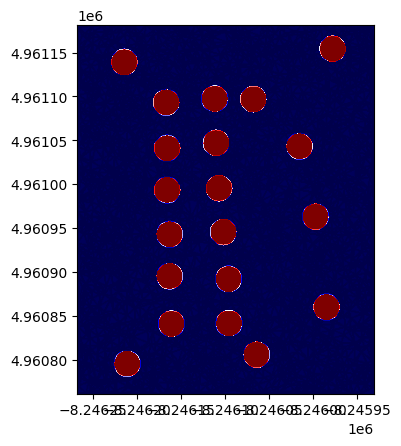

In [50]:
#read the raster
raster = rio.open('files/obstacle_raster.tif')

img = rio.plot.show(raster, cmap='seismic')

In [51]:
#route the track through the raster
ds = ds.route_through_raster(raster, 
                             tracks=track_ids, 
                             ncores=4,
                             fully_connected=True)

#get routed tracks
routed = ds.to_gdf(tracks=track_ids)

Routing tracks through raster:   0%|          | 0/38 [00:00<?, ?it/s]

Converting tracks to GeoDataFrame: 100%|██████████| 38/38 [00:00<00:00, 83.42it/s] 


<Axes: >

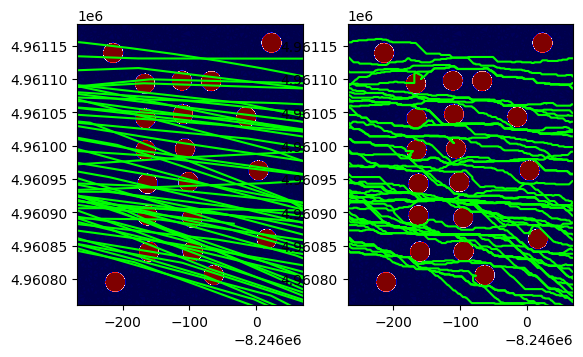

In [53]:
#plot the two
fig, ax = plt.subplots(1,2)

#original
original.plot(ax=ax[0], color='lime')
show(raster, ax=ax[0], cmap='seismic')

#routed
routed.plot(ax=ax[1], color='lime')
show(raster, ax=ax[1], cmap='seismic')
